# Тестовое задание на позицию Computer Vision Data Scientist

# MODEL FROM SCRATCH

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Задача

> **Необходимо построить классификатор деталей по фотографиям, который будет предсказывать один из двух классов: «маленькая» или «большая» деталь на изображении.**

> **Необходимо добиться максимальной точности предсказания классов.**

**В качестве решения необходимо приложить:**
- код обучения модели (может быть оформлен как .ipynb-ноутбук или файл с расширением .py)

- код использования модели (должен являться программным файлом расширения .py) со всеми необходимыми файлами для возможности проверки работы решения (например, весами обученной модели)

- файл readme с описанием запуска файла использования модели.

**Формат решения:** ссылка на репозиторий со всеми перечисленными файлами решения.

#### Время выполнения задания: 3 дня

**Данные**
- Имеются фотографии двух деталей – около 40 фотографий «большой» детали и около 20 фотографий «маленькой» детали.
- Две трети фотографий отнесены к обучающей выборке, треть – к тестовой.

Данные внутри обучающей и тестовых выборок разбиты на два класса: «маленькие» и «большие».

Ссылка на данные - https://drive.google.com/file/d/1RDAeRaX526vcZ4PcZnYqSFqsibmxMdmd/view


## Анализ решения 
1. Поставлена задача бинарной классификации изображений
1. Необходимо сделать исследование лучших моделей для ее решения 
1. Отобрать 3 кандидата на основании поиска и реализовать их 
1. Обучить модели 
1. Сделать сравнительный анализ результатов и отобрать лучшее решение 
1. Сделать развертывание лучшего решения 

**Особенности**

Нет ограничения на время обучения модели, главное добиться максимальной точности. 


### IMPORT LIBRARIES

In [2]:
# GENERAL
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# PATH PROCESS
import os
import os.path
from pathlib import Path
import glob
import itertools

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, f1_score, precision_score, recall_score

import tensorflow as tf
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import Activation, Dense, Dropout, Flatten, Conv2D, MaxPooling2D, MaxPool2D, \
    AveragePooling2D, GlobalMaxPooling2D

from tensorflow.keras.preprocessing import image

from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.utils import to_categorical  # convert to one-hot-encoding
from tensorflow.keras import regularizers
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
from tensorflow.keras.metrics import PrecisionAtRecall, Recall

import warnings
warnings.simplefilter(action="ignore", category=FutureWarning)

### PATH & LABEL PROCESS

In [3]:
# Main path
train_data_path = '/content/drive/MyDrive/Test_task_computer_vision/data/train/'

test_data_path = '/content/drive/MyDrive/Test_task_computer_vision/data/test/'

In [4]:
classes = {"big": "0", "small": "1"}

In [5]:
all_filenames_train = []
all_categories_train = []
for classElement in classes:
    filenames = os.listdir(train_data_path + classElement)
    all_filenames_train += [classElement + "/" + file for file in filenames]
    all_categories_train += [classes[classElement]] * len(filenames)

In [6]:
train_df = pd.DataFrame({'PICTURE': all_filenames_train,
                         'CATEGORY': all_categories_train})

In [7]:
# Checking results
train_df.tail()

,PICTURE,CATEGORY
38,small/IMG_7901.jpeg,1
39,small/IMG_7903.jpeg,1
40,small/IMG_7904.jpeg,1
41,small/IMG_7906.jpeg,1
42,small/IMG_7907.jpeg,1


In [8]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43 entries, 0 to 42
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   PICTURE   43 non-null     object
 1   CATEGORY  43 non-null     object
dtypes: object(2)
memory usage: 816.0+ bytes


In [9]:
all_filenames_test = []
all_categories_test = []
for classElement in classes:
    filenames = os.listdir(test_data_path + classElement)
    all_filenames_test += [classElement + "/" + file for file in filenames]
    all_categories_test += [classes[classElement]] * len(filenames)

In [10]:
test_df = pd.DataFrame({'PICTURE': all_filenames_test,
                        'CATEGORY': all_categories_test})

In [11]:
# Checking results
test_df.tail()

,PICTURE,CATEGORY
16,small/IMG_7896.jpeg,1
17,small/IMG_7899.jpeg,1
18,small/IMG_7902.jpeg,1
19,small/IMG_7905.jpeg,1
20,small/IMG_7915.jpeg,1


In [12]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21 entries, 0 to 20
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   PICTURE   21 non-null     object
 1   CATEGORY  21 non-null     object
dtypes: object(2)
memory usage: 464.0+ bytes


In [13]:
# Shuffling train data 
train_df = train_df.sample(frac=1, random_state=42).reset_index(drop=True)
train_df.head()

,PICTURE,CATEGORY
0,small/IMG_7900.jpeg,1
1,big/IMG_7849.jpeg,0
2,big/IMG_7852.jpeg,0
3,small/IMG_7898.jpeg,1
4,small/IMG_7895.jpeg,1


### VISUALIZATION: Distribution of classes

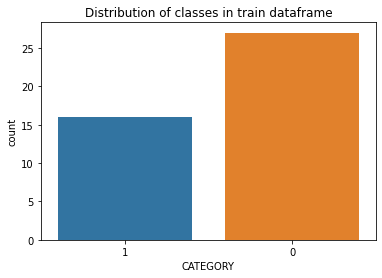

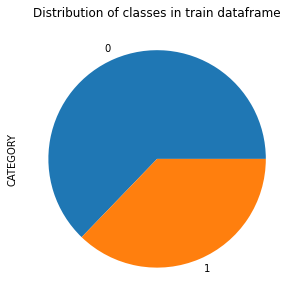

In [14]:
# General
sns.countplot(train_df["CATEGORY"])
plt.title('Distribution of classes in train dataframe')
plt.show()

plt.title('Distribution of classes in train dataframe')
train_df['CATEGORY'].value_counts().plot.pie(figsize=(5, 5))
plt.show()

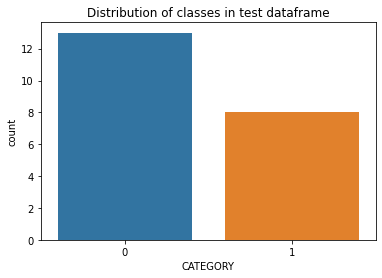

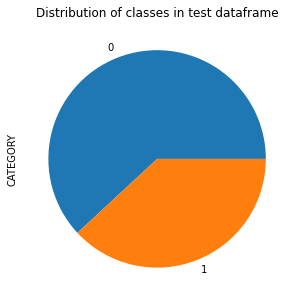

In [15]:
sns.countplot(test_df["CATEGORY"])
plt.title('Distribution of classes in test dataframe')
plt.show()

plt.title('Distribution of classes in test dataframe')
test_df['CATEGORY'].value_counts().plot.pie(figsize=(5, 5))
plt.show()

### DATA PREPARATION

In [16]:
print(f'Train class value counts: \n{train_df["CATEGORY"].value_counts()}')
print(f'Test class value counts: \n{test_df["CATEGORY"].value_counts()}')

Train class value counts: 
0    27
1    16
Name: CATEGORY, dtype: int64
Test class value counts: 
0    13
1     8
Name: CATEGORY, dtype: int64


#### Image generator

In [17]:
train_generator = ImageDataGenerator(rescale=1. / 256,
                                     shear_range=0.25,
                                     zoom_range=0.2,
                                     rotation_range=30,
                                     width_shift_range=0.15,
                                     height_shift_range=0.15,
                                     horizontal_flip=True,
                                     vertical_flip=True,
                                     fill_mode='reflect')

In [18]:
validation_generator = ImageDataGenerator(rescale=1. / 256)

In [19]:
test_generator = ImageDataGenerator(rescale=1. / 256)

#### Applying generator and transformation to tensor

In [20]:
print("Preparing the training data:")
train_images = train_generator.flow_from_dataframe(train_df,
                                                   directory=train_data_path,
                                                   x_col='PICTURE',
                                                   y_col='CATEGORY',
                                                   target_size=(500, 500),
                                                   class_mode='binary',
                                                   batch_size=24)


Preparing the training data:
Found 43 validated image filenames belonging to 2 classes.


In [21]:
print("Preparing the validation data:")
valid_images = validation_generator.flow_from_dataframe(train_df,
                                                        directory=train_data_path,
                                                        x_col='PICTURE',
                                                        y_col='CATEGORY',
                                                        target_size=(500, 500),
                                                        class_mode='binary',
                                                        batch_size=24)

Preparing the validation data:
Found 43 validated image filenames belonging to 2 classes.


In [22]:
print("Preparing the test data:")
test_images = test_generator.flow_from_dataframe(dataframe=test_df,
                                                 directory=test_data_path,
                                                 x_col='PICTURE',
                                                 y_col='CATEGORY',
                                                 target_size=(500, 500),
                                                 class_mode='binary',
                                                 batch_size=24)

Preparing the test data:
Found 21 validated image filenames belonging to 2 classes.


In [23]:
# Checking
print("Checking the training data:")
for data_batch, label_batch in train_images:
    print("DATA SHAPE: ", data_batch.shape)
    print("LABEL SHAPE: ", label_batch.shape)
    break

Checking the training data:
DATA SHAPE:  (24, 500, 500, 3)
LABEL SHAPE:  (24,)


In [24]:
print("Checking the validation data:")
for data_batch, label_batch in valid_images:
    print("DATA SHAPE: ", data_batch.shape)
    print("LABEL SHAPE: ", label_batch.shape)
    break

Checking the validation data:
DATA SHAPE:  (24, 500, 500, 3)
LABEL SHAPE:  (24,)


In [25]:
print("Checking the test data:")
for data_batch, label_batch in test_images:
    print("DATA SHAPE: ", data_batch.shape)
    print("LABEL SHAPE: ", label_batch.shape)
    break

Checking the test data:
DATA SHAPE:  (21, 500, 500, 3)
LABEL SHAPE:  (21,)


### Evaluation and visualization of model parameters

In [26]:
def learning_curves(history):
    pd.DataFrame(history.history).plot(figsize=(20, 8))
    plt.grid(True)
    plt.title('Learning curves')
    plt.gca().set_ylim(0, 1)
    plt.show()


def evaluation_model(history):
    fig, (axL, axR) = plt.subplots(ncols=2, figsize=(20, 8))
    axL.plot(history.history['loss'], label="Training loss")
    axL.plot(history.history['val_loss'], label="Validation loss")
    axL.set_title('Training and Validation loss')
    axL.set_xlabel('Epochs')
    axL.set_ylabel('Loss')
    axL.legend(loc='upper right')

    axR.plot(history.history['accuracy'], label="Training accuracy")
    axR.plot(history.history['val_accuracy'], label="Validation accuracy")
    axR.set_title('Training and Validation accuracy')
    axR.set_xlabel('Epoch')
    axR.set_ylabel('Accuracy')
    axR.legend(loc='upper right')

    plt.show()


def model_confusion_matrix(y_true, y_pred, classes=None, figsize=(10, 10), text_size=15):
    # Create the confustion matrix
    cm = confusion_matrix(y_true, y_pred)
    cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]
    n_classes = cm.shape[0]

    # Plot the figure and make it pretty
    fig, ax = plt.subplots(figsize=figsize)
    cax = ax.matshow(cm, cmap=plt.cm.Blues)  # colors will represent how 'correct' a class is, darker == better
    fig.colorbar(cax)

    # Are there a list of classes?
    if classes:
        labels = classes
    else:
        labels = np.arange(cm.shape[0])

    # Label the axes
    ax.set(title="Confusion Matrix",
           xlabel="Predicted label",
           ylabel="True label",
           xticks=np.arange(n_classes),  # create enough axis slots for each class
           yticks=np.arange(n_classes),
           xticklabels=labels,  # axes will labeled with class names (if they exist) or ints
           yticklabels=labels)

    # Make x-axis labels appear on bottom
    ax.xaxis.set_label_position("bottom")
    ax.xaxis.tick_bottom()

    # Set the threshold for different colors
    threshold = (cm.max() + cm.min()) / 2.

    # Plot the text on each cell
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, f"{cm[i, j]} ({cm_norm[i, j] * 100:.1f}%)",
                 horizontalalignment="center",
                 color="white" if cm[i, j] > threshold else "black",
                 size=text_size)
    plt.show()

# MODEL: Tiny VGG

In [28]:

model = Sequential([
  Conv2D(50, 3, activation='relu', input_shape=(500, 500, 3)),
  Conv2D(50, 3, activation='relu'),
  MaxPool2D(),
  Conv2D(50, 3, activation='relu'),
  Conv2D(50, 3, activation='relu'),
  MaxPool2D(),
  Flatten(),
  Dense(64, activation='relu'),
  Dense(1, activation='sigmoid')
])


In [29]:
# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(),
                  loss='binary_crossentropy',
                  metrics=["accuracy"])

In [30]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 498, 498, 50)      1400      
                                                                 
 conv2d_1 (Conv2D)           (None, 496, 496, 50)      22550     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 248, 248, 50)     0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 246, 246, 50)      22550     
                                                                 
 conv2d_3 (Conv2D)           (None, 244, 244, 50)      22550     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 122, 122, 50)     0         
 2D)                                                    

In [31]:
history = model.fit(train_images,
                    validation_data=valid_images,
                    epochs=10)

Epoch 1/10
2/2 [==============================] - 31s 22s/step - loss: 6.9051 - accuracy: 0.6279 - val_loss: 0.6521 - val_accuracy: 0.6279
Epoch 2/10
2/2 [==============================] - 22s 15s/step - loss: 1.2518 - accuracy: 0.4651 - val_loss: 0.8178 - val_accuracy: 0.3721
Epoch 3/10
2/2 [==============================] - 22s 17s/step - loss: 0.7678 - accuracy: 0.6047 - val_loss: 1.1737 - val_accuracy: 0.3721
Epoch 4/10
2/2 [==============================] - 22s 17s/step - loss: 0.9512 - accuracy: 0.4186 - val_loss: 0.6950 - val_accuracy: 0.6279
Epoch 5/10
2/2 [==============================] - 22s 17s/step - loss: 0.6887 - accuracy: 0.6279 - val_loss: 0.6807 - val_accuracy: 0.6279
Epoch 6/10
2/2 [==============================] - 22s 17s/step - loss: 0.6926 - accuracy: 0.5116 - val_loss: 0.6715 - val_accuracy: 0.6279
Epoch 7/10
2/2 [==============================] - 22s 17s/step - loss: 0.6773 - accuracy: 0.6279 - val_loss: 0.6614 - val_accuracy: 0.6279
Epoch 8/10
2/2 [===========

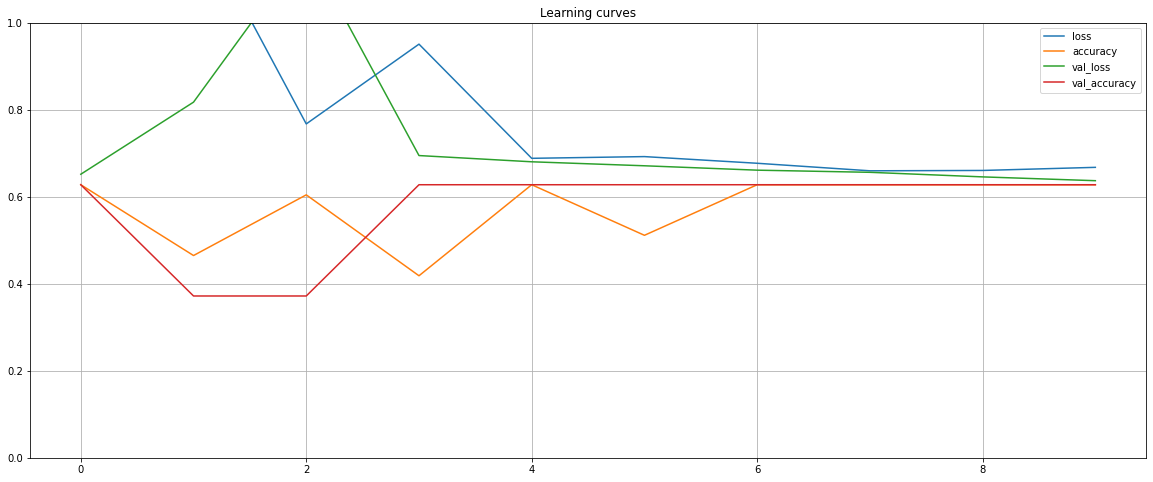

In [32]:
# Learning curves
learning_curves(history)

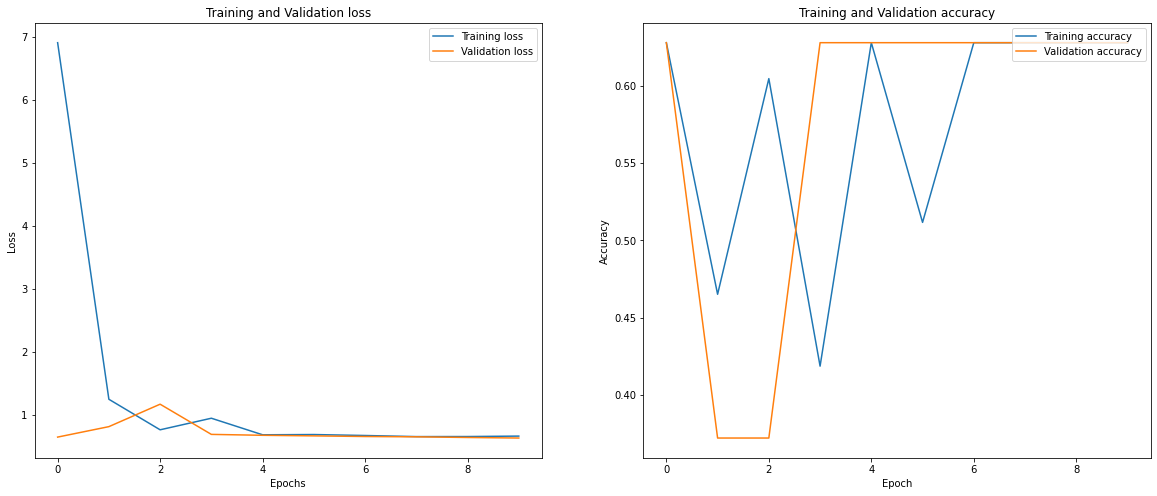

In [33]:
# Evaluation model
evaluation_model(history)

In [34]:
# Evaluate the model on the test set
evaluate = model.evaluate(test_images, verbose=2)

1/1 - 6s - loss: 0.6425 - accuracy: 0.6190 - 6s/epoch - 6s/step


In [35]:
# Predicting the test set results
threshold = 0.5

y_pred = model.predict(test_images)
y_pred_class = np.where(y_pred > threshold, 1,0)

prediction_class = LabelEncoder().fit_transform(test_df["CATEGORY"])

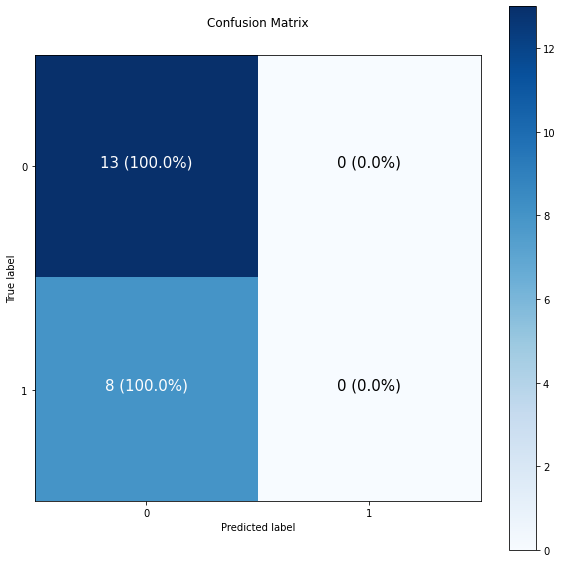

In [36]:
# Confusion matrix
model_confusion_matrix(prediction_class, y_pred_class)

In [37]:
# Classification report
report = classification_report(prediction_class, y_pred_class, target_names=['big','small'])
print(report)

              precision    recall  f1-score   support

         big       0.62      1.00      0.76        13
       small       0.00      0.00      0.00         8

    accuracy                           0.62        21
   macro avg       0.31      0.50      0.38        21
weighted avg       0.38      0.62      0.47        21



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
